# Consumer Complaint Text Classification

Customer service is vital in many industries. Helping and responding to your consumers swiftly and accurately plays a crucial role in retaining customers by keeping them saitsfied and informed. 
One way of increasing speed and efficiency in dealing with these situations is to have a program that immediately classifies a type of complaint or inquiry of a consumer and directly directs them to experts in respective areas. This saves time for both the customers and the businesses by getting rid of an entire layer of communication.

In this notebook, different models are used and compared in solving the problem of classifying financial complaints from the US Consumer Finance Complaints available on Kaggle. Codes/scripts were inspired/brought from works of Susan Li (https://towardsdatascience.com/@actsusanli) and zqhZY (https://github.com/zqhZY?tab=repositories) and modified to different extents to either fit the problem or (to attempt) to enhance the results.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Cleaning Data (this step does not have to be run if you replace the dataset with the already cleaned 'complaints_cleaned.csv' or complaints_cleaned_label.csv' datasets).
First load the data.

In [ ]:
df = pd.read_csv('consumer_complaints.csv')
df.reset_index()
df.head()

Drop all rows that do not have complaints as they are not particularly useful. This drastically reduces the amount of data.

In [ ]:
df = df[['product', 'consumer_complaint_narrative']]

df = df.dropna()
df.head()

In [ ]:
df.shape

To have an idea of the data distribution of the categories, plot the data. It can be seen that debt collection has the largest amount of relevant complaints. Although in some situations normalizing the amount may be helpful, in this case taking in count what consumers generally complain the most about may actually help us better predict the categories.

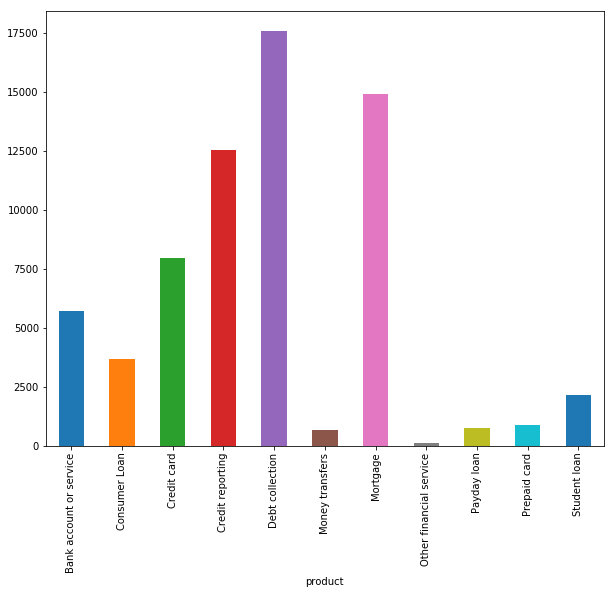

In [5]:
fig = plt.figure(figsize=(10,8))
df.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [6]:
df['consumer_complaint_narrative'].apply(lambda x: len(x.split(' '))).sum()

12804227

Before anything, it's good to make sure that all the words are clean, meaning not having punctuations next to them and also get rid of the random slahes (/) and 'X' that appears in the data.

In [7]:

from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('/', '')
    return text

In [8]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(cleanText)


In [9]:
df = df[['product', 'consumer_complaint_narrative']]
df.head()

,product,consumer_complaint_narrative
190126,Debt collection,has claimed i owe them {$27.00} for years de...
190135,Consumer Loan,due to inconsistencies in the amount owed that...
190155,Mortgage,in my wages that i earned at my job decreased...
190207,Mortgage,i have an open and current mortgage with chase...
190208,Mortgage,was submitted . at the time i submitted this ...


### Logistic + Doc2Vec

Word2Vec is a numeric interpretation of individual words.
Doc2Vec is the same, but with documents.
Generally good for sentence similarity tasks, so it seemed like a reasonable approach when trying to predict consumer complaint topics.


Here we label the complaints in order to use Doc2Vec later on.

In [10]:

from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Split dataset.

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['consumer_complaint_narrative'], df['product'], random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

Now, train a Doc2Vec model with Distributed Bag of Words (DBOW) using the Gensim package. The DBOW, according to Le and Mikolov, samples a text window at each iteration. Then, it samples a random word from the text window and forms a classification task given the Paragraph Vector.

In [17]:
from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 66806/66806 [00:00<00:00, 2270076.91it/s]


In [ ]:
from sklearn import utils


for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [97]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

Use Logistic Regression with the doc2vec embeddings.

In [98]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
logreg.score(test_vectors_dbow, y_test)

0.8111964873765093

The accuracy above is pretty good considering that previous similar implementations of this achieved around 65~70%. Below, we save the DBOW model.

In [100]:

model_dbow.save('d2v_model_dbow.doc2vec')

Up next is Doc2Vec with Distributed Memory(DM). DM acts as a memory that remembers what is missing from the current context.  

In [101]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 66806/66806 [00:00<00:00, 1795919.02it/s]


In [102]:
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|███████████████████████████████████████████████████████████████████████| 66806/66806 [00:00<00:00, 1547989.49it/s]


In [103]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [104]:
logreg.fit(train_vectors_dm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [105]:
logreg.score(test_vectors_dm, y_test)

0.7736752819079932

The accuracy for this is a bit lower than DBOW, but still relatively higher than other previous similar implementations (40~60%)

In [106]:
model_dm.save('d2v_model_dm.doc2vec')

In [107]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

It has been said that combining these two can lead to better results. The function below concactenates the results genrated from DBOW and DM.

In [108]:
def get_concat_vectors(model1, model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix], model2.docvecs[prefix])
    return vectors

In [109]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow, model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow, model_dm, len(X_test), 600, 'Test')

In [110]:
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
logreg.score(test_vecs_dbow_dm, y_test)

0.8221235405648138

And the rumors are right! The model has been improved by a drastic 1%!

In [35]:
df = df.applymap(cleanText)


In [66]:

df.to_csv('complaints_cleaned.csv')

### CNN and LSTM
Below, CNN and LSTM will be used to tackle this problem. By doing both we would be able to see a clear comparison between a CNN and a type of RNN model to see which one is better for this particular text classification problem. The LSTM will also be using the DBOW model we trained earlier in the hopes that this will help in finding relationships or links between complaints and categories.

PyTorch will be used from here on.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from importlib import reload

class TextCNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_classes, kernel_num, kernel_sizes, dropout):
        super(TextCNN, self).__init__()

        
        V = vocab_size
        D = embed_dim
        C = num_classes
        Cin = 1
        Cout = kernel_num
        Ks = kernel_sizes


        self.embeding = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Cin, Cout, (K, D)) for K in Ks])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(Ks) * Cout, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N,Co,W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeding(x)

        x = x.unsqueeze(1)
        x= [F.relu(conv(x).squeeze(3)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)

        '''
                x1 = self.conv_and_pool(x,self.conv13) #(N,Co)
                x2 = self.conv_and_pool(x,self.conv14) #(N,Co)
                x3 = self.conv_and_pool(x,self.conv15) #(N,Co)
                x = torch.cat((x1, x2, x3), 1) # (N,len(Ks)*Co)
        '''
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [148]:
from torch import nn
import torch
import numpy as np


class TextLSTM(nn.Module):
    """
    lstm model of text classify.
    """
    def __init__(self, vocab_size, hidden_size, linear_hidden_size, 
                 embed_dim, num_classes, embedding_path):
        self.name = "TextLstm"
        super(TextLSTM, self).__init__()
        

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(input_size = embed_dim,
                            hidden_size = hidden_size,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = False)

        self.linears = nn.Sequential(
            nn.Linear(hidden_size, linear_hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(linear_hidden_size, num_classes),
         
        )

        if embedding_path:
            self.embedding.weight.data.copy_(torch.from_numpy
                                             (np.load(embedding_path)))
    

    def forward(self, x):
        x = self.embedding(x)
        print (x)
        lstm_out, _ = self.lstm(x)

      
        out = self.linears(lstm_out[:, -1, :])
       
        return out


In [149]:
import sys
import torch
import os
import torch.autograd as autograd
import torch.nn.functional as F


def fit(train, val, model, cuda, lr, epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    h = []
    v = []

    t = []
 
    
    if cuda:
        model.cuda()
    steps = 0
    model.train()
    best_accuracy = 0
    for epoch in range(1, epochs + 1):
        for batch in train:
            print(batch)
            feature, target = batch.consumer_complaint_narrative, batch.category_id
      
            
            feature.data.t_()
            target.data.sub_(1)

            if cuda:
                feature, target = feature.cuda(), target.cuda()
            optimizer.zero_grad()

            out = model(feature)
            
      
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()

            steps += 1
            if steps % 1 == 0:
                # print torch.max(out, 1)[1].view(target.size()).data
                corrects = (torch.max(out, 1)[1].view(target.size()).data == target.data).double().sum()
                accuracy = 100.0 * corrects / batch.batch_size
                sys.stdout.write(
                    '\rBatch[{}] - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(steps,
                                                                             loss.item(),
                                                                             accuracy,
                                                                             corrects,
                                                                             batch.batch_size))
                
            if steps % 10 == 0:
                current_accuracy = eval(val, model, cuda)
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy

                    print("save model at step %s, accuracy is %d".format(str(steps), current_accuracy))
   
                    torch.save(model, 'save_pathff')
                
                h.append(steps)
                v.append(current_accuracy)
            
    plt.xlabel('Steps')
    plt.ylabel('Development Accuracy')    
    plt.plot(h, v)
        


def eval(data_iter, model, cuda):
    model.eval()
    
    corrects, avg_loss = 0, 0


    for batch in data_iter:
        feature, target = batch.consumer_complaint_narrative, batch.category_id
        target.data.sub_(1)  # batch first, index align
        feature.data.t_()
      

        if cuda:
            feature, target = feature.cuda(), target.cuda()

        logit = model(feature)
        loss = F.cross_entropy(logit, target, size_average=False)

        avg_loss += loss.item()
        corrects += (torch.max(logit, 1)
                     [1].view(target.size()).data == target.data).double().sum()

    size = len(data_iter.dataset)
    avg_loss = loss.item() / size
    accuracy = 100.0 * corrects / size
    model.train()
    print('\nEvaluation - loss: {:.6f}  acc: {:.4f}%({}/{}) \n'.format(avg_loss,
                                                                       accuracy,
                                                                       corrects,
                                                                        size))
    return accuracy

In [150]:
import random
from torchtext import data
from torchtext.data import Dataset
from sklearn.model_selection import KFold
import numpy as np


class MyDataset(data.TabularDataset):
    """
    """

    def splits(self, fields, dev_ratio=.15, shuffle=True, **kwargs):
        """Create dataset objects for splits of the MR dataset.
        Arguments:
            fields: The field that will be used for the sentence.
            label_field: The field that will be used for label data.
            dev_ratio: The ratio that will be used to get split validation dataset.
            shuffle: Whether to shuffle the data before split.
        """
        examples = self.examples
        if shuffle: random.shuffle(examples)

        dev_index = -1 * int(dev_ratio * len(examples))
        return (Dataset(fields=fields, examples=examples[:dev_index]),
                Dataset(fields=fields, examples=examples[dev_index:]))

    def kfold(self, k):
        """
        kfold using sklearn
        :param k:
        :return: index of kfolded
        """
        kf = KFold(k)
        examples = self.examples
        return kf.split(examples)

    def get_fold(self, fields, train_indexs, test_indexs, shuffle=True):
        """
        get new batch
        :return:
        """
        examples = np.asarray(self.examples)

        if shuffle: random.shuffle(examples)
        print (list(train_indexs))
        return (Dataset(fields=fields, examples=examples[list(train_indexs)]),
                Dataset(fields=fields, examples=examples[list(test_indexs)]))

In [ ]:
import argparse
import sys
from gensim.models import doc2vec
import numpy as np
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from torchtext import data
from torchtext.data import TabularDataset






TEXT = data.Field()
LABELS = data.Field(sequential=False)
dataset = MyDataset(path='./complaints_cleaned_label.csv', format='csv', 
                    fields=[("product", None), ('consumer_complaint_narrative', TEXT), 
                            ('category_id', LABELS)])
train, dev = dataset.splits(fields=[("product", None), ('consumer_complaint_narrative', TEXT), 
                                    ('category_id', LABELS)])

# print(train.fields)
# print(len(train))
# print(vars(train[0]))

LABELS.build_vocab(dataset.category_id)
TEXT.build_vocab(dataset.consumer_complaint_narrative)

print(TEXT.vocab.freqs.most_common(10))
print(LABELS.vocab.itos)

train_iter, dev_iter = data.Iterator.splits((train, dev), sort=False,
                                            batch_sizes=(1000, len(dev)))

EMBEDDING_FILE = 'd2v_model_dbow.doc2vec'
MAX_NB_WORDS = 50000
embedding_matrix_path = "./embedding_matrix.npy"
########################################
# prepare embeddings
########################################

print('Preparing embedding matrix')
word2vec = Doc2Vec.load(EMBEDDING_FILE)

nb_words = min(MAX_NB_WORDS, len(TEXT.vocab))

embedding_matrix = np.zeros((nb_words, 300))
c = 0
for i, word in enumerate(TEXT.vocab.itos):
    if word in word2vec.wv.vocab and i < 50000:
        embedding_matrix[i] = word2vec.wv.word_vec(word)
    else:
        c += 1
        # print word
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
np.save(embedding_matrix_path, embedding_matrix)



vocab_size = len(TEXT.vocab)
num_classes = 12
embedding_path = embedding_matrix_path
kernel_sizes = [1, 1, 1]
embed_dim = 3
kernel_num = 30
cuda = False
dropout = 0.3
lr = 0.001
epochs = 256
cnn = TextCNN(vocab_size, embed_dim, num_classes, kernel_num, kernel_sizes, dropout)

fit(train_iter, dev_iter, cnn, cuda, lr, epochs)



[('the', 524857), ('i', 476386), ('to', 434550), ('and', 345431), ('a', 261266), ('my', 255679), ('of', 199905), ('that', 196005), ('was', 174111), ('they', 157167)]
['<unk>', '0', '2', '4', '3', '6', '1', '5', '10', '7', '8', '9', 'category_id']
Preparing embedding matrix
Null word embeddings: 3

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1] - loss: 2.700723  acc: 11.5000%(115.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2] - loss: 2.609316  acc: 11.6000%(116.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3] - loss: 2.480200  acc: 13.3000%(133.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_n

C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation - loss: 1.975330  acc: 27.8116%(2787.0/10021) 

save model at step %s, accuracy is %d


C:\Users\Hoyoung Jun\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type TextCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[11] - loss: 2.063287  acc: 22.3000%(223.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[12] - loss: 2.074861  acc: 23.7000%(237.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[13] - loss: 2.081103  acc: 23.6000%(236.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[14] - loss: 2.056958  acc: 24.1000%(241.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of

	[.category_id]:[torch.LongTensor of size 1000]
Batch[48] - loss: 1.997510  acc: 22.3000%(223.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[49] - loss: 1.968258  acc: 25.9000%(259.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[50] - loss: 1.942508  acc: 24.5000%(245.0/1000)
Evaluation - loss: 1.888585  acc: 29.7376%(2980.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[51] - loss: 1.992862  acc: 25.3000%(253.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[85] - loss: 1.955215  acc: 27.2000%(272.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[86] - loss: 1.898634  acc: 28.7000%(287.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[87] - loss: 1.901975  acc: 28.3000%(283.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[88] - loss: 1.954351  acc: 26.3000%(263.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[89] - loss: 1.904042  acc: 28.0000%(280.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.c

	[.category_id]:[torch.LongTensor of size 1000]
Batch[122] - loss: 1.951307  acc: 26.6000%(266.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[123] - loss: 1.923116  acc: 29.2000%(292.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[124] - loss: 1.883899  acc: 30.8000%(308.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[125] - loss: 1.876910  acc: 29.7000%(297.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[126] - loss: 1.899847  acc: 27.4000%(274.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[159] - loss: 1.847427  acc: 30.8000%(308.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[160] - loss: 1.932858  acc: 27.4000%(274.0/1000)
Evaluation - loss: 1.855774  acc: 32.6415%(3271.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[161] - loss: 1.897981  acc: 28.1000%(281.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[162] - loss: 1.970210  acc: 24.0000%(240.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[196] - loss: 1.899026  acc: 27.7000%(277.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[197] - loss: 1.862452  acc: 31.4000%(314.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[198] - loss: 1.875515  acc: 31.0000%(310.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[199] - loss: 1.943504  acc: 30.3000%(303.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[200] - loss: 1.915538  acc: 30.9000%(309.0/1000)
Evaluation - loss: 1.844251  acc: 33.9088

	[.category_id]:[torch.LongTensor of size 1000]
Batch[233] - loss: 1.828713  acc: 33.3000%(333.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[234] - loss: 1.806182  acc: 36.6000%(366.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[235] - loss: 1.904862  acc: 30.9000%(309.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[236] - loss: 1.869509  acc: 31.6000%(316.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[237] - loss: 1.887547  acc: 29.9000%(299.0/1000)
[torchtext.data.batch.Batch of size 1000]

Batch[270] - loss: 1.853966  acc: 32.5000%(325.0/1000)
Evaluation - loss: 1.821311  acc: 34.5973%(3467.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 756x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[271] - loss: 1.863045  acc: 33.3000%(333.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[272] - loss: 1.855961  acc: 32.9000%(329.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[273] - loss: 1.859924  acc: 30.5000%(305.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[274] - loss: 1.848023  acc: 34.9000%(349.0/1000)
[torchtext.data.batch.Batch o

	[.category_id]:[torch.LongTensor of size 1000]
Batch[307] - loss: 1.852026  acc: 33.1000%(331.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[308] - loss: 1.851371  acc: 31.9000%(319.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[309] - loss: 1.818326  acc: 34.5000%(345.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 712x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[310] - loss: 1.806181  acc: 36.0000%(360.0/1000)
Evaluation - loss: 1.801245  acc: 36.4534%(3653.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000

Batch[343] - loss: 1.735531  acc: 37.5000%(375.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[344] - loss: 1.803958  acc: 36.3000%(363.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[345] - loss: 1.774957  acc: 36.7000%(367.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[346] - loss: 1.794093  acc: 34.6000%(346.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[347] - loss: 1.808623  acc: 37.0000%(370.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTen

Batch[380] - loss: 1.794348  acc: 37.4000%(374.0/1000)
Evaluation - loss: 1.758611  acc: 38.6987%(3878.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[381] - loss: 1.774082  acc: 35.7000%(357.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[382] - loss: 1.783739  acc: 38.8000%(388.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[383] - loss: 1.805703  acc: 35.8000%(358.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[384] - loss: 1.786459  acc: 35.3000%(353.0/1000)
[torchtext.data.batch.Batch o

	[.category_id]:[torch.LongTensor of size 1000]
Batch[417] - loss: 1.768406  acc: 37.5000%(375.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[418] - loss: 1.766438  acc: 37.5000%(375.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[419] - loss: 1.757545  acc: 38.6000%(386.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[420] - loss: 1.732308  acc: 38.6000%(386.0/1000)
Evaluation - loss: 1.723683  acc: 40.9041%(4099.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[454] - loss: 1.759954  acc: 38.4000%(384.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[455] - loss: 1.774665  acc: 37.2000%(372.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[456] - loss: 1.729911  acc: 38.0407%(299.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[457] - loss: 1.736100  acc: 38.7000%(387.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[458] - loss: 1.698475  acc: 41.5000%(415.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[491] - loss: 1.659492  acc: 42.2000%(422.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[492] - loss: 1.689597  acc: 40.9000%(409.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[493] - loss: 1.643947  acc: 43.6000%(436.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[494] - loss: 1.727985  acc: 40.3000%(403.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x

Batch[527] - loss: 1.612550  acc: 43.0000%(430.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[528] - loss: 1.643835  acc: 41.9000%(419.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[529] - loss: 1.585627  acc: 46.1000%(461.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[530] - loss: 1.651017  acc: 42.8000%(428.0/1000)
Evaluation - loss: 1.625837  acc: 44.0675%(4416.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[531] - loss: 1.583622  acc: 46.4000%(46

	[.category_id]:[torch.LongTensor of size 1000]
Batch[564] - loss: 1.607066  acc: 45.6000%(456.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[565] - loss: 1.607038  acc: 43.4000%(434.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[566] - loss: 1.590592  acc: 44.2000%(442.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[567] - loss: 1.680847  acc: 42.4000%(424.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[568] - loss: 1.631696  acc: 44.4000%(444.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[601] - loss: 1.609251  acc: 45.8000%(458.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[602] - loss: 1.627303  acc: 42.7000%(427.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[603] - loss: 1.630461  acc: 44.5000%(445.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[604] - loss: 1.651223  acc: 41.6000%(416.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[605] - loss: 1.628311  acc: 44.1000%(441.0/1000)
[torchtext.data.batch.Batch of size 1000]

Batch[638] - loss: 1.670408  acc: 43.4000%(434.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[639] - loss: 1.633963  acc: 44.1000%(441.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[640] - loss: 1.589310  acc: 44.4000%(444.0/1000)
Evaluation - loss: 1.537017  acc: 46.8716%(4697.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[641] - loss: 1.533428  acc: 47.7000%(477.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[642] - loss: 1.552505  acc: 48.2000%(482.0/1000)
[torchtext.data.batch.Batch o

	[.category_id]:[torch.LongTensor of size 1000]
Batch[675] - loss: 1.551337  acc: 45.8000%(458.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[676] - loss: 1.531381  acc: 48.2000%(482.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[677] - loss: 1.567276  acc: 47.0000%(470.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[678] - loss: 1.526091  acc: 47.7000%(477.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[679] - loss: 1.605444  acc: 43.2000%(432.0/1000)
[torchtext.data.batch.Batch of size 1000]

Batch[711] - loss: 1.483014  acc: 51.2000%(512.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[712] - loss: 1.500620  acc: 49.5000%(495.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[713] - loss: 1.535646  acc: 49.0000%(490.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[714] - loss: 1.524414  acc: 47.2000%(472.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[715] - loss: 1.581935  acc: 45.1000%(451.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTen

Batch[748] - loss: 1.539514  acc: 48.4000%(484.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[749] - loss: 1.489439  acc: 49.4000%(494.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[750] - loss: 1.514035  acc: 47.8000%(478.0/1000)
Evaluation - loss: 1.463734  acc: 49.7755%(4988.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[751] - loss: 1.483608  acc: 49.8000%(498.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[752] - loss: 1.466175  acc: 50.4000%(504

	[.category_id]:[torch.LongTensor of size 1000]
Batch[785] - loss: 1.486943  acc: 48.5000%(485.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[786] - loss: 1.447986  acc: 50.4000%(504.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[787] - loss: 1.506126  acc: 45.9000%(459.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[788] - loss: 1.504888  acc: 48.0000%(480.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[789] - loss: 1.561324  acc: 46.6000%(466.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[822] - loss: 1.406178  acc: 51.9000%(519.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[823] - loss: 1.537033  acc: 48.7000%(487.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[824] - loss: 1.513423  acc: 48.4000%(484.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[825] - loss: 1.432728  acc: 50.4000%(504.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[826] - loss: 1.445413  acc: 51.7000%(517.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[859] - loss: 1.453807  acc: 51.6000%(516.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[860] - loss: 1.462287  acc: 49.9000%(499.0/1000)
Evaluation - loss: 1.405264  acc: 52.2104%(5232.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[861] - loss: 1.463652  acc: 50.6000%(506.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[862] - loss: 1.401513  acc: 53.3000%(533.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[896] - loss: 1.375537  acc: 55.4000%(554.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[897] - loss: 1.439238  acc: 50.6000%(506.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[898] - loss: 1.407998  acc: 52.4000%(524.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[899] - loss: 1.405281  acc: 52.9000%(529.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[900] - loss: 1.385887  acc: 54.1000%(541.0/1000)
Evaluation - loss: 1.388105  acc: 52.4598

	[.category_id]:[torch.LongTensor of size 1000]
Batch[933] - loss: 1.434157  acc: 54.1000%(541.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[934] - loss: 1.425334  acc: 52.2000%(522.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[935] - loss: 1.403701  acc: 52.5000%(525.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[936] - loss: 1.396212  acc: 51.1000%(511.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[937] - loss: 1.412619  acc: 53.8000%(538.0/1000)
[torchtext.data.batch.Batch of size 1000]

	[.category_id]:[torch.LongTensor of size 1000]
Batch[970] - loss: 1.435451  acc: 52.0000%(520.0/1000)
Evaluation - loss: 1.356712  acc: 54.3559%(5447.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[971] - loss: 1.411523  acc: 54.2000%(542.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[972] - loss: 1.436204  acc: 52.4000%(524.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[973] - loss: 1.383993  acc: 54.2000%(542.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1007] - loss: 1.415973  acc: 52.4000%(524.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1008] - loss: 1.340431  acc: 54.2000%(542.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1009] - loss: 1.423444  acc: 52.0000%(520.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1010] - loss: 1.447643  acc: 52.2000%(522.0/1000)
Evaluation - loss: 1.342248  acc: 54.7251%(5484.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1043] - loss: 1.371093  acc: 52.9000%(529.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1044] - loss: 1.369862  acc: 55.0000%(550.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1045] - loss: 1.366828  acc: 54.1000%(541.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1046] - loss: 1.362243  acc: 53.4000%(534.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1047] - loss: 1.348774  acc: 55.7000%(557.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[1080] - loss: 1.356711  acc: 55.3000%(553.0/1000)
Evaluation - loss: 1.318062  acc: 55.4635%(5558.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1081] - loss: 1.428086  acc: 50.8000%(508.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1082] - loss: 1.406961  acc: 54.7000%(547.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[1083] - loss: 1.282789  acc: 55.3435%(435.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1084] - loss: 1.292910  acc: 56.5000%(5

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1117] - loss: 1.379015  acc: 52.7000%(527.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1118] - loss: 1.321846  acc: 55.4000%(554.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1119] - loss: 1.424984  acc: 52.2000%(522.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1120] - loss: 1.385188  acc: 49.9000%(499.0/1000)
Evaluation - loss: 1.305340  acc: 55.7928%(5591.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size

Batch[1153] - loss: 1.376401  acc: 54.6000%(546.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1154] - loss: 1.298372  acc: 56.4000%(564.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1155] - loss: 1.306263  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1156] - loss: 1.296981  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1157] - loss: 1.328964  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1190] - loss: 1.377888  acc: 54.4000%(544.0/1000)
Evaluation - loss: 1.282907  acc: 56.7209%(5684.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1191] - loss: 1.303751  acc: 55.6000%(556.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1192] - loss: 1.301926  acc: 56.4000%(564.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1193] - loss: 1.295306  acc: 56.7000%(567.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1227] - loss: 1.359868  acc: 53.1000%(531.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1228] - loss: 1.265242  acc: 57.5000%(575.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1229] - loss: 1.307661  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1230] - loss: 1.332229  acc: 57.0000%(570.0/1000)
Evaluation - loss: 1.270273  acc: 57.1300%(5725.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1263] - loss: 1.300813  acc: 57.6000%(576.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1264] - loss: 1.299972  acc: 57.0000%(570.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1265] - loss: 1.268449  acc: 57.0000%(570.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1266] - loss: 1.255999  acc: 58.9000%(589.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1267] - loss: 1.358668  acc: 55.6000%(556.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1300] - loss: 1.246782  acc: 59.8000%(598.0/1000)
Evaluation - loss: 1.252291  acc: 58.1479%(5827.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1301] - loss: 1.247466  acc: 57.8000%(578.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1302] - loss: 1.277176  acc: 57.5000%(575.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1303] - loss: 1.339056  acc: 54.9000%(549.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1336] - loss: 1.270097  acc: 58.4000%(584.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1337] - loss: 1.298081  acc: 57.4000%(574.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1338] - loss: 1.278714  acc: 58.1000%(581.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1339] - loss: 1.239872  acc: 60.9000%(609.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1340] - loss: 1.230443  acc: 59.6000%(596.0/1000)
Evaluation - loss: 1.241056  acc: 58.7067%(5883.0/10021) 

save model at step %s, ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1373] - loss: 1.220841  acc: 59.8000%(598.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1374] - loss: 1.295700  acc: 56.9000%(569.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1375] - loss: 1.275362  acc: 57.4000%(574.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1376] - loss: 1.250721  acc: 57.6000%(576.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1377] - loss: 1.200388  acc: 61.5000%(615.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1410] - loss: 1.206030  acc: 59.4000%(594.0/1000)
Evaluation - loss: 1.219588  acc: 59.8244%(5995.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1411] - loss: 1.239652  acc: 59.7000%(597.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1412] - loss: 1.262763  acc: 58.2000%(582.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1413] - loss: 1.254733  acc: 59.1000%(591.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1446] - loss: 1.257587  acc: 60.8000%(608.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1447] - loss: 1.245192  acc: 59.0000%(590.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1448] - loss: 1.201457  acc: 60.5000%(605.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1449] - loss: 1.170413  acc: 61.6000%(616.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1450] - loss: 1.225722  acc: 61.5000%(615.0/1000)
Evaluation - loss: 1.207996  acc: 60.1637%(6029.0/10021) 


[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1483] - loss: 1.184862  acc: 61.1000%(611.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1484] - loss: 1.180376  acc: 62.2000%(622.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1485] - loss: 1.141409  acc: 63.4000%(634.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1486] - loss: 1.244248  acc: 57.3000%(573.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1487] - loss: 1.234099  acc: 59.5000%(595.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1520] - loss: 1.188280  acc: 60.6000%(606.0/1000)
Evaluation - loss: 1.183101  acc: 61.2314%(6136.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1521] - loss: 1.180467  acc: 60.0000%(600.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1522] - loss: 1.230926  acc: 59.9000%(599.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1523] - loss: 1.178316  acc: 60.7000%(607.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1557] - loss: 1.170696  acc: 62.0000%(620.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1558] - loss: 1.199250  acc: 61.4000%(614.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1559] - loss: 1.208566  acc: 60.0000%(600.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1560] - loss: 1.156923  acc: 64.1000%(641.0/1000)
Evaluation - loss: 1.172273  acc: 61.5308%(6166.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1593] - loss: 1.152932  acc: 62.8000%(628.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1594] - loss: 1.262533  acc: 58.6000%(586.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1595] - loss: 1.126140  acc: 62.6000%(626.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[1596] - loss: 1.195374  acc: 60.5598%(476.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1597] - loss: 1.175556  acc: 60.5000%(605.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTe

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1630] - loss: 1.224500  acc: 61.8000%(618.0/1000)
Evaluation - loss: 1.156141  acc: 62.2094%(6234.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1631] - loss: 1.206427  acc: 60.7000%(607.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1632] - loss: 1.167536  acc: 62.1000%(621.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1633] - loss: 1.171308  acc: 61.1000%(611.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1666] - loss: 1.169650  acc: 61.2000%(612.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 740x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1667] - loss: 1.140699  acc: 63.0000%(630.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1668] - loss: 1.144348  acc: 61.5000%(615.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1669] - loss: 1.174860  acc: 61.2000%(612.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1670] - loss: 1.226454  acc: 60.9000%(609.0/1000)
Evaluation - loss: 1.148888  acc: 62.4089%(6254.0/10021) 


[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1703] - loss: 1.246202  acc: 60.0000%(600.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1704] - loss: 1.192496  acc: 60.8000%(608.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1705] - loss: 1.177086  acc: 60.1000%(601.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1706] - loss: 1.151334  acc: 62.1000%(621.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1707] - loss: 1.173232  acc: 61.7000%(617.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1740] - loss: 1.217198  acc: 60.3000%(603.0/1000)
Evaluation - loss: 1.134861  acc: 62.9678%(6310.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1741] - loss: 1.160452  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1742] - loss: 1.238882  acc: 58.6000%(586.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1743] - loss: 1.163327  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1744] - loss: 1.098393  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1777] - loss: 1.105963  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1778] - loss: 1.129064  acc: 63.0000%(630.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1779] - loss: 1.155903  acc: 62.2000%(622.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1780] - loss: 1.102669  acc: 64.9000%(649.0/1000)
Evaluation - loss: 1.129509  acc: 63.0875%(6322.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1813] - loss: 1.229121  acc: 60.9000%(609.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1814] - loss: 1.187868  acc: 60.9000%(609.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1815] - loss: 1.095861  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1816] - loss: 1.086881  acc: 65.6000%(656.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1817] - loss: 1.098510  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1850] - loss: 1.119146  acc: 61.3000%(613.0/1000)
Evaluation - loss: 1.120289  acc: 63.4068%(6354.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1851] - loss: 1.149407  acc: 63.8000%(638.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1852] - loss: 1.127965  acc: 63.6000%(636.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1853] - loss: 1.167183  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 

Batch[1886] - loss: 1.098254  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1887] - loss: 1.120931  acc: 63.6000%(636.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1888] - loss: 1.121202  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1889] - loss: 1.058259  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1890] - loss: 1.209619  acc: 62.0000%(620.0/1000)
Evaluation - loss: 1.114535  acc: 63.7362%(6387.0/10021) 

save model at step %s, a

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1923] - loss: 1.151850  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1924] - loss: 1.094745  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1925] - loss: 1.080369  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1926] - loss: 1.103999  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1927] - loss: 1.129273  acc: 64.1000%(641.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1960] - loss: 1.188591  acc: 61.1000%(611.0/1000)
Evaluation - loss: 1.107030  acc: 63.8759%(6401.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1961] - loss: 1.085312  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1962] - loss: 1.125657  acc: 63.4000%(634.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1963] - loss: 1.119427  acc: 66.0000%(660.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1964] - loss: 1.063569  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[1997] - loss: 1.143137  acc: 62.3000%(623.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1998] - loss: 1.089974  acc: 66.1000%(661.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[1999] - loss: 1.097430  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2000] - loss: 1.094025  acc: 63.6000%(636.0/1000)
Evaluation - loss: 1.102774  acc: 63.9158%(6405.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2001] - loss: 1.100314  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2034] - loss: 1.145317  acc: 63.1000%(631.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2035] - loss: 1.143660  acc: 63.1000%(631.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2036] - loss: 1.091914  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2037] - loss: 1.093773  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2038] - loss: 1.101936  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2071] - loss: 1.102286  acc: 64.3000%(643.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2072] - loss: 1.038853  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2073] - loss: 1.089510  acc: 64.3000%(643.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2074] - loss: 1.054079  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2075] - loss: 1.074026  acc: 64.4000%(644.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2108] - loss: 1.156737  acc: 63.9000%(639.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[2109] - loss: 1.121191  acc: 62.9771%(495.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2110] - loss: 1.059409  acc: 67.1000%(671.0/1000)
Evaluation - loss: 1.091575  acc: 64.5045%(6464.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2111] - loss: 1.129728  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000

Batch[2144] - loss: 1.088167  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2145] - loss: 1.138405  acc: 62.8000%(628.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2146] - loss: 1.104143  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2147] - loss: 1.038848  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2148] - loss: 1.127052  acc: 64.4000%(644.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.L

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2181] - loss: 1.087590  acc: 63.4000%(634.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2182] - loss: 1.067953  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2183] - loss: 1.074895  acc: 64.5000%(645.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2184] - loss: 1.126526  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2185] - loss: 1.072354  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2218] - loss: 1.124086  acc: 64.2000%(642.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2219] - loss: 1.122363  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2220] - loss: 1.129439  acc: 65.8000%(658.0/1000)
Evaluation - loss: 1.080915  acc: 64.9436%(6508.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2221] - loss: 1.102873  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2255] - loss: 1.048614  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2256] - loss: 1.090556  acc: 63.9000%(639.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2257] - loss: 1.056325  acc: 65.8000%(658.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2258] - loss: 1.028174  acc: 68.7000%(687.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2259] - loss: 1.075750  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2292] - loss: 1.074526  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2293] - loss: 1.042221  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 752x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2294] - loss: 1.037669  acc: 66.8000%(668.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2295] - loss: 1.137131  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2296] - loss: 1.100553  acc: 65.1000%(651.0/1000)
[torchtext.data.batch.Batch of size

Batch[2329] - loss: 1.171456  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2330] - loss: 1.092347  acc: 66.3000%(663.0/1000)
Evaluation - loss: 1.071381  acc: 65.0933%(6523.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 722x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2331] - loss: 1.145110  acc: 65.2000%(652.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2332] - loss: 1.044539  acc: 64.8000%(648.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2333] - loss: 1.073498  acc: 63.5000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2366] - loss: 1.052377  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2367] - loss: 1.075553  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2368] - loss: 1.064511  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2369] - loss: 1.161297  acc: 62.9000%(629.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2370] - loss: 1.062255  acc: 64.3000%(643.0/1000)
Evaluation - loss: 1.069451  acc: 65

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2403] - loss: 1.088679  acc: 64.4000%(644.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2404] - loss: 1.078851  acc: 64.5000%(645.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2405] - loss: 1.053632  acc: 66.7000%(667.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2406] - loss: 1.062183  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2407] - loss: 1.160838  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2440] - loss: 1.073771  acc: 65.9000%(659.0/1000)
Evaluation - loss: 1.064667  acc: 65.3627%(6550.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2441] - loss: 1.019644  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2442] - loss: 1.050501  acc: 67.3000%(673.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2443] - loss: 1.015206  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2444] - loss: 1.022778  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2477] - loss: 1.087682  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2478] - loss: 1.040404  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2479] - loss: 1.038247  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2480] - loss: 1.053869  acc: 66.2000%(662.0/1000)
Evaluation - loss: 1.062217  acc: 65.3428%(6548.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2481] - loss: 1.072088  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2514] - loss: 1.002469  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2515] - loss: 1.041124  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2516] - loss: 1.010862  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2517] - loss: 1.103307  acc: 64.7000%(647.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2518] - loss: 1.050809  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2551] - loss: 1.012185  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2552] - loss: 1.055903  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2553] - loss: 1.033759  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2554] - loss: 1.085412  acc: 64.9000%(649.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2555] - loss: 1.023189  acc: 67.1000%(671.0/1000)
[torchtext.data.batch.Batch of size 

Batch[2588] - loss: 1.145858  acc: 64.2000%(642.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2589] - loss: 1.081458  acc: 64.3000%(643.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2590] - loss: 1.017153  acc: 67.3000%(673.0/1000)
Evaluation - loss: 1.056360  acc: 65.5024%(6564.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2591] - loss: 1.030352  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2592] - loss: 1.098460  acc: 64.2000%(642.0/1000)
[torchtext.data.batch.Ba

Batch[2625] - loss: 1.060307  acc: 63.8000%(638.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2626] - loss: 1.073572  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2627] - loss: 1.118631  acc: 63.3000%(633.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2628] - loss: 1.029824  acc: 67.1000%(671.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2629] - loss: 1.076256  acc: 62.4000%(624.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2662] - loss: 1.019442  acc: 66.7000%(667.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2663] - loss: 1.060185  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2664] - loss: 1.013350  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2665] - loss: 1.042677  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2666] - loss: 1.083238  acc: 65.3000%(653.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2699] - loss: 1.025910  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2700] - loss: 1.027360  acc: 66.5000%(665.0/1000)
Evaluation - loss: 1.053378  acc: 65.5823%(6572.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2701] - loss: 1.069525  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2702] - loss: 1.076997  acc: 66.9000%(669.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2703] - loss: 1.028483  ac

	[.category_id]:[torch.LongTensor of size 786]
Batch[2736] - loss: 0.999585  acc: 68.5751%(539.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 778x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2737] - loss: 0.953028  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 823x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2738] - loss: 1.085577  acc: 65.1000%(651.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2739] - loss: 1.081223  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2740] - loss: 1.059270  acc: 65.7000%(657.0/1000)
Evaluation - loss: 1.049589  acc: 65.5

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2773] - loss: 1.123549  acc: 63.5000%(635.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2774] - loss: 1.025211  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2775] - loss: 1.034809  acc: 65.6000%(656.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2776] - loss: 1.046854  acc: 67.3000%(673.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2777] - loss: 1.070334  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size

Batch[2810] - loss: 1.017274  acc: 68.5000%(685.0/1000)
Evaluation - loss: 1.045200  acc: 65.6122%(6575.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2811] - loss: 1.022552  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2812] - loss: 1.034401  acc: 65.3000%(653.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2813] - loss: 1.092703  acc: 64.6000%(646.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2814] - loss: 1.016106  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2847] - loss: 1.028782  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2848] - loss: 1.006454  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2849] - loss: 1.077846  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[2850] - loss: 1.061011  acc: 66.1578%(520.0/786)
Evaluation - loss: 1.041726  acc: 65.8118%(6595.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2851] - loss: 1.088421  acc: 6

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2884] - loss: 0.962238  acc: 68.7000%(687.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2885] - loss: 1.037338  acc: 66.1000%(661.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2886] - loss: 1.029643  acc: 67.1000%(671.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2887] - loss: 1.012384  acc: 65.6000%(656.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2888] - loss: 1.078652  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2921] - loss: 1.059919  acc: 65.9000%(659.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2922] - loss: 0.958485  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 726x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2923] - loss: 1.006156  acc: 67.6000%(676.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2924] - loss: 1.038743  acc: 66.0000%(660.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2925] - loss: 1.045530  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 

Batch[2958] - loss: 1.031210  acc: 65.7000%(657.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2959] - loss: 1.031031  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2960] - loss: 1.066870  acc: 66.8000%(668.0/1000)
Evaluation - loss: 1.036166  acc: 65.8717%(6601.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2961] - loss: 0.993724  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2962] - loss: 1.028141  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[2995] - loss: 1.024574  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2996] - loss: 0.983052  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2997] - loss: 1.027947  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2998] - loss: 0.981367  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[2999] - loss: 0.959031  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

Batch[3031] - loss: 1.067678  acc: 66.2000%(662.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3032] - loss: 1.027786  acc: 67.4000%(674.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3033] - loss: 0.991660  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 723x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3034] - loss: 0.926700  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3035] - loss: 1.058894  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.Lo

Batch[3068] - loss: 0.975104  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3069] - loss: 1.005517  acc: 69.5000%(695.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3070] - loss: 1.035694  acc: 66.7000%(667.0/1000)
Evaluation - loss: 1.028599  acc: 66.2908%(6643.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3071] - loss: 1.083844  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3072] - loss: 1.015985  acc: 68.0000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3105] - loss: 0.987972  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3106] - loss: 0.976572  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3107] - loss: 0.997259  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3108] - loss: 1.002312  acc: 67.3000%(673.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3109] - loss: 0.965027  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3142] - loss: 0.956403  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3143] - loss: 1.085436  acc: 65.0000%(650.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3144] - loss: 0.990240  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3145] - loss: 1.047544  acc: 65.5000%(655.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3146] - loss: 1.034077  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 

Batch[3179] - loss: 1.010842  acc: 66.6000%(666.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3180] - loss: 1.028533  acc: 66.9000%(669.0/1000)
Evaluation - loss: 1.021286  acc: 66.4006%(6654.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3181] - loss: 1.009386  acc: 67.7000%(677.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3182] - loss: 1.035585  acc: 65.8000%(658.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 750x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3183] - loss: 1.000619  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Ba

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3216] - loss: 1.077621  acc: 65.4000%(654.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3217] - loss: 0.961845  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 746x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3218] - loss: 0.947244  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3219] - loss: 1.008451  acc: 66.3000%(663.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3220] - loss: 1.011831  acc: 68.2000%(682.0/1000)
Evaluation - loss: 1.017283  acc: 66

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3253] - loss: 0.974843  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3254] - loss: 1.062327  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3255] - loss: 1.048928  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3256] - loss: 1.016412  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3257] - loss: 0.971974  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3290] - loss: 1.010184  acc: 67.9000%(679.0/1000)
Evaluation - loss: 1.013079  acc: 66.6800%(6682.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3291] - loss: 0.971376  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 721x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3292] - loss: 0.999683  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3293] - loss: 1.066922  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3294] - loss: 0.995418  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3327] - loss: 1.022586  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 747x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3328] - loss: 0.927993  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3329] - loss: 0.992172  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3330] - loss: 1.030869  acc: 67.0000%(670.0/1000)
Evaluation - loss: 1.013205  acc: 66.8197%(6696.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3331] - loss: 1.000261  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3364] - loss: 0.964284  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3365] - loss: 0.993754  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3366] - loss: 0.930275  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3367] - loss: 1.022235  acc: 68.2000%(682.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 751x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3368] - loss: 0.961432  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3401] - loss: 0.998947  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3402] - loss: 0.977493  acc: 69.8000%(698.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3403] - loss: 0.903469  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3404] - loss: 0.926301  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3405] - loss: 0.936968  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3438] - loss: 0.958880  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3439] - loss: 0.952860  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3440] - loss: 1.085152  acc: 66.5000%(665.0/1000)
Evaluation - loss: 1.003343  acc: 67.0692%(6721.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3441] - loss: 0.975572  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3475] - loss: 0.964311  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3476] - loss: 0.998292  acc: 68.9000%(689.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[3477] - loss: 0.997298  acc: 68.0662%(535.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3478] - loss: 1.062227  acc: 66.8000%(668.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3479] - loss: 0.986794  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3512] - loss: 0.933473  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3513] - loss: 0.916519  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3514] - loss: 0.962699  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3515] - loss: 0.929794  acc: 71.2000%(712.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3516] - loss: 0.922541  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3549] - loss: 0.998809  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 800x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3550] - loss: 1.026032  acc: 65.3000%(653.0/1000)
Evaluation - loss: 0.997865  acc: 67.1789%(6732.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3551] - loss: 0.999702  acc: 67.5000%(675.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3552] - loss: 0.992098  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 755x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3553] - loss: 0.946599  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3586] - loss: 0.979563  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3587] - loss: 0.987996  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 782x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3588] - loss: 0.962994  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3589] - loss: 0.955312  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3590] - loss: 0.991386  acc: 69.0000%(690.0/1000)
Evaluation - loss: 0.993167  acc: 67

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3623] - loss: 0.960707  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3624] - loss: 0.896800  acc: 69.7000%(697.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3625] - loss: 1.011401  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3626] - loss: 0.902918  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 1283x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3627] - loss: 0.975800  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3660] - loss: 0.924294  acc: 69.6000%(696.0/1000)
Evaluation - loss: 0.988359  acc: 67.4184%(6756.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 806x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3661] - loss: 0.965158  acc: 68.7000%(687.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 760x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3662] - loss: 1.057369  acc: 66.4000%(664.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3663] - loss: 0.968959  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3664] - loss: 0.956827  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3697] - loss: 0.975320  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3698] - loss: 1.002183  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3699] - loss: 0.965145  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3700] - loss: 0.950547  acc: 69.9000%(699.0/1000)
Evaluation - loss: 0.985792  acc: 67.6080%(6775.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 735x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3701] - loss: 0.898410  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3734] - loss: 0.909267  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3735] - loss: 0.953464  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 730x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3736] - loss: 0.970861  acc: 70.8000%(708.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 743x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3737] - loss: 1.005883  acc: 67.9000%(679.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3738] - loss: 0.908628  acc: 72.0000%(720.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3771] - loss: 0.966555  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3772] - loss: 0.977670  acc: 67.6000%(676.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3773] - loss: 0.909199  acc: 68.5000%(685.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3774] - loss: 0.935574  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 763x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3775] - loss: 0.950094  acc: 68.4000%(684.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3808] - loss: 0.948848  acc: 67.0000%(670.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3809] - loss: 0.955361  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 717x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3810] - loss: 0.963276  acc: 68.4000%(684.0/1000)
Evaluation - loss: 0.978202  acc: 67.9074%(6805.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3811] - loss: 0.987828  acc: 66.7000%(667.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3812] - loss: 0.970127  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3845] - loss: 0.916540  acc: 68.2000%(682.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3846] - loss: 1.001686  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 745x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3847] - loss: 0.939005  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3848] - loss: 0.934862  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3849] - loss: 0.941162  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3882] - loss: 0.913694  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 808x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3883] - loss: 0.923422  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3884] - loss: 0.938465  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3885] - loss: 0.934394  acc: 69.7000%(697.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 753x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3886] - loss: 0.970026  acc: 68.3000%(683.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3919] - loss: 0.943868  acc: 68.3000%(683.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 742x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3920] - loss: 1.024620  acc: 67.6000%(676.0/1000)
Evaluation - loss: 0.971316  acc: 68.2666%(6841.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3921] - loss: 0.920689  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 737x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3922] - loss: 0.946856  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3923] - loss: 0.930789  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3956] - loss: 0.975040  acc: 68.1000%(681.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 736x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3957] - loss: 0.968877  acc: 69.0000%(690.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3958] - loss: 0.909229  acc: 69.4000%(694.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 757x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3959] - loss: 0.955750  acc: 68.9000%(689.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 744x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3960] - loss: 0.928049  acc: 70.6000%(706.0/1000)
Evaluation - loss: 0.969654  acc: 68

	[.category_id]:[torch.LongTensor of size 1000]
Batch[3993] - loss: 0.957955  acc: 69.6000%(696.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 770x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3994] - loss: 0.950970  acc: 69.1000%(691.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3995] - loss: 0.957461  acc: 71.0000%(710.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3996] - loss: 0.963779  acc: 69.3000%(693.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[3997] - loss: 0.981541  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4030] - loss: 0.885725  acc: 71.7000%(717.0/1000)
Evaluation - loss: 0.964455  acc: 68.6159%(6876.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4031] - loss: 0.929350  acc: 70.0000%(700.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 785x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4032] - loss: 0.913988  acc: 71.4000%(714.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4033] - loss: 0.993647  acc: 67.2000%(672.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 754x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4067] - loss: 0.926892  acc: 69.9000%(699.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4068] - loss: 0.993571  acc: 66.5000%(665.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4069] - loss: 0.902821  acc: 71.6000%(716.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4070] - loss: 0.917831  acc: 68.0000%(680.0/1000)
Evaluation - loss: 0.963127  acc: 68.7556%(6890.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 819x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 786]
Batch[4104] - loss: 0.833919  acc: 74.3003%(584.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 772x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4105] - loss: 0.920005  acc: 70.5000%(705.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 766x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4106] - loss: 0.912888  acc: 70.8000%(708.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 790x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4107] - loss: 0.992202  acc: 68.2000%(682.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 739x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4108] - loss: 0.888911  acc: 70.9000%(709.0/1000)
[torchtext.data.batch.Batch of size 10

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4141] - loss: 0.970096  acc: 67.8000%(678.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 771x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4142] - loss: 0.958563  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 797x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4143] - loss: 0.890485  acc: 71.5000%(715.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4144] - loss: 0.967684  acc: 68.8000%(688.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 748x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4145] - loss: 0.901208  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4178] - loss: 0.931636  acc: 69.8000%(698.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 729x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4179] - loss: 0.933451  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4180] - loss: 0.904369  acc: 72.2000%(722.0/1000)
Evaluation - loss: 0.956969  acc: 68.8354%(6898.0/10021) 


[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 795x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4181] - loss: 0.959329  acc: 70.1000%(701.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 776x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4182] - loss: 0.900459  ac

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4215] - loss: 0.908238  acc: 71.8000%(718.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 731x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4216] - loss: 0.888849  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 764x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4217] - loss: 0.839151  acc: 73.9000%(739.0/1000)
[torchtext.data.batch.Batch of size 786]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 804x786]
	[.category_id]:[torch.LongTensor of size 786]
Batch[4218] - loss: 0.961619  acc: 69.0840%(543.0/786)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4219] - loss: 0.894140  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4252] - loss: 0.934840  acc: 69.2000%(692.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 765x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4253] - loss: 0.890661  acc: 73.1000%(731.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 733x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4254] - loss: 0.921958  acc: 70.2000%(702.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 741x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4255] - loss: 0.960715  acc: 68.6000%(686.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 762x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4256] - loss: 0.899710  acc: 71.5000%(715.0/1000)
[torchtext.data.batch.Batch of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4289] - loss: 0.928837  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 728x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4290] - loss: 0.865104  acc: 71.5000%(715.0/1000)
Evaluation - loss: 0.953751  acc: 69.1847%(6933.0/10021) 

save model at step %s, accuracy is %d

[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4291] - loss: 0.872667  acc: 72.1000%(721.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 777x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4292] - loss: 0.898292  acc: 71.1000%(711.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 758x1000]
	[.category_id]:[torch.LongTensor of size 

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4326] - loss: 0.908466  acc: 70.3000%(703.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 732x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4327] - loss: 1.022643  acc: 68.3000%(683.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 749x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4328] - loss: 0.896167  acc: 72.5000%(725.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 781x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4329] - loss: 0.890833  acc: 70.4000%(704.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 779x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4330] - loss: 0.960431  acc: 69.0000%(690.0/1000)
Evaluation - loss: 0.948838  acc: 69

	[.category_id]:[torch.LongTensor of size 1000]
Batch[4363] - loss: 0.889767  acc: 71.7000%(717.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 734x1000]
	[.category_id]:[torch.LongTensor of size 1000]
Batch[4364] - loss: 0.850431  acc: 72.2000%(722.0/1000)
[torchtext.data.batch.Batch of size 1000]
	[.consumer_complaint_narrative]:[torch.LongTensor of size 783x1000]
	[.category_id]:[torch.LongTensor of size 1000]


In [ ]:
hidden_size = 7
linear_hidden_size = 10
embed_dim = 3

EMBEDDING_FILE = 'd2v_model_dbow.doc2vec'
MAX_NB_WORDS = 66808
embedding_matrix_path = "./embedding_matrix.npy"
########################################
# prepare embeddings
########################################

print('Preparing embedding matrix')
word2vec = Doc2Vec.load(EMBEDDING_FILE)

nb_words = min(MAX_NB_WORDS, len(TEXT.vocab))

embedding_matrix = np.zeros((nb_words, 3))
c = 0
for i, word in enumerate(TEXT.vocab.itos):
    if word in word2vec.wv.vocab:
        embedding_matrix[i] = word2vec.wv.word_vec(word)
    else:
        c += 1
        # print word
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
np.save(embedding_matrix_path, embedding_matrix)

lstm = TextLSTM(vocab_size, hidden_size, linear_hidden_size, embed_dim, num_classes, embedding_path)
fit(train_iter, dev_iter, lstm, cuda, lr, epochs)